In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from IPython.display import clear_output
import time
from numba import jit

In [2]:
plt.rcParams['figure.figsize'] = [8, 8]

In [3]:
@jit
def valid_polygon(point_array):
    l = point_array.shape[0]
    for i in range(-1,l - 1):
        p1, p2 = point_array[i],point_array[i+1]
        for j in range(-1,l - 1):
            if j%l == i%l or j%l == (i+1)%l or j%l == (i-1)%l:
                continue
            p3, p4 = point_array[j],point_array[j+1]
            if intersect(p1,p2,p3,p4):
                return False
    return True
@jit 
def ccw(p1,p2,p3):
    (x1,y1) = p1
    (x2,y2) = p2
    (x3,y3) = p3
    return (y3-y1) * (x2-x1) > (y2-y1) * (x3-x1)
@jit
def intersect(p1,p2,p3,p4):
    (x1,y1) = p1
    (x2,y2) = p2
    (x3,y3) = p3
    (x4,y4) = p4
    test1 = ccw((x1,y1),(x3,y3),(x4,y4)) != ccw((x2,y2),(x3,y3),(x4,y4))
    test2 = ccw((x1,y1),(x2,y2),(x3,y3)) != ccw((x1,y1),(x2,y2),(x4,y4))
    return test1 and test2

@jit
def in_bounds(point_array):
    if np.any(point_array[:,0]>1):
        return False
    if np.any(point_array[:,1]>1):
        return False
    if np.any(np.bitwise_and(point_array[:,0]<0,point_array[:,1]<0)):
        return False
    
    for i in range(-1,point_array.shape[0] - 1):
        p1, p2 = point_array[i],point_array[i+1]
        x1,y1 = p1
        x2,y2 = p2
        if not geometrystuff(x1,y1,x2,y2):
            return False
    return True

@jit
def finished(point_array):
    if np.all(point_array[:,0]>=0):
        return True
    elif np.all(point_array[:,0]>=point_array[:,1]):
        return True
    else:
        return False
@jit
def geometrystuff(x1,y1,x2,y2):
    a,b = 0,0
    if y1 == y2 or x1 == x2:
        return True
    a = x1 - (y1 * (x2 - x1) / (y2 - y1))
    if a<0 and (a<min(x1,x2) or a>max(x1,x2)):
        a = 1
    b = y1 - (x1 * (y2 - y1) / (x2 - x1))
    if b<0 and (b<min(y1,y2) or b>max(y1,y2)):
        b = 1
    if a >= 0 and b >= 0:
        return True
    else:
        return False
@jit
def area(point_array):
    x, y = point_array[:,0], point_array[:,1]
    return np.abs(1/2 * np.sum(x*np.roll(y, 1) - y*np.roll(x, 1)))

"""
#OLD AND SLOW
@jit
def max_angle(point_array,step = 0.03):
    angle = 0
    while True:
        angle -= step
        rot = np.array([[math.cos(angle), -math.sin(angle)], [math.sin(angle), math.cos(angle)]])
        new_point_array = np.dot(point_array,rot.T)
        if in_bounds(new_point_array):
            continue
        else:
            angle += step
            rot = np.array([[math.cos(angle), -math.sin(angle)], [math.sin(angle), math.cos(angle)]])
            new_point_array = np.dot(point_array,rot.T)
            return new_point_array, angle
"""
@jit
def max_angle(point_array,multiplier = 0.99):
    max_angle = 2*math.pi
    for point in point_array:
        radius = np.sum(np.square(point))**0.5
        current_angle = math.atan2(point[1],point[0])
        if current_angle < -2:
            current_angle += 2 * math.pi
        if radius>1:
            circle_angle = math.acos(1/radius)
            if current_angle >= math.pi/2: 
                min_angle = current_angle - math.pi/2 - circle_angle
            elif current_angle >= 0:
                min_angle = current_angle - circle_angle
            else:
                min_angle = current_angle + math.pi / 2
        else:
            min_angle = current_angle + math.pi / 2
        max_angle = min(min_angle,max_angle)
        
    angle = - max_angle * multiplier
    rot = np.array([[math.cos(angle), -math.sin(angle)], [math.sin(angle), math.cos(angle)]])
    new_point_array = np.dot(point_array,rot.T)
    return new_point_array, angle

@jit
def move_down_edges(point_array):
    miny = 1
    for i in range(-1,point_array.shape[0]-1):
        p1, p2 = point_array[i],point_array[i+1]
        if max(p1[0],p2[0])>0 and min(p1[0],p2[0])<0:
            miny = min(miny,(p2[0]*p1[1] - p1[0]*p2[1])/(p2[0] - p1[0]))
    return miny

        
def pass_through(point_array,max_steps,plot_graph = False):
    for steps in range(max_steps):
        stuck = True
        #Rotate about 0,0 as much as possible
        point_array, angle = max_angle(point_array)
        if angle != 0:
            stuck = False
            
        #Move ahead if in bounds
        distx = np.min(1 - point_array[:,0])
        if in_bounds(point_array +  np.array((distx/2,0))):
            point_array += np.array((distx*0.99,0))
            stuck = False
            
        #End condition
        if finished(point_array):
            stuck = False
            break
            
        #Move down if in bounds
        disty = min(move_down_edges(point_array),np.min(point_array[:,1][point_array[:,0]<0]))
        point_array -= np.array((0,disty))
        
        if stuck:
            break
        
        #Plot
        if plot_graph:
            plt.plot(np.append(point_array[:,0], point_array[0,0]), 
                     np.append(point_array[:,1], point_array[0,1]))
            plt.plot((-3,1,1),(1,1,-3))
            plt.plot((-3,0,0),(0,0,-3))
            plt.show()
            clear_output(wait=True)
            
    if plot_graph:
        print(steps)
    if steps != 0 and steps != max_steps-1 and not stuck:
        return True
    else:
        return False
    
def reduce_useless_points(og_point_array,max_steps=400):
    while True:
        initial_shape = og_point_array.shape
        for i in reversed(range(og_point_array.shape[0])):
            new_point_list = list(og_point_array)
            del new_point_list[i]
            og_point_array2 = np.array(new_point_list)
            if area(og_point_array2) >= area(og_point_array):
                if pass_through(og_point_array2,max_steps):
                    og_point_array = og_point_array2 * 1
        if og_point_array.shape == initial_shape:
            break
    return og_point_array
            
def grow(og_point_array,max_steps=400,multiplier=0.001):
    og_point_array2 = og_point_array * 1
    center = np.mean(og_point_array,axis = 0)
    for i in range(og_point_array.shape[0]):
        
        og_point_array2 = og_point_array * 1
        og_point_array2[i] += multiplier*(og_point_array2[i] - center)
        if area(og_point_array2)  > area(og_point_array):
            if in_bounds(og_point_array2) and valid_polygon(og_point_array2) and np.all(og_point_array2[:,1]>=0):
                if pass_through(og_point_array2,max_steps):
                    og_point_array = og_point_array2 * 1
        
        og_point_array2 = og_point_array * 1
        og_point_array2[i,0] += multiplier
        if area(og_point_array2)  > area(og_point_array):
            if in_bounds(og_point_array2) and valid_polygon(og_point_array2) and np.all(og_point_array2[:,1]>=0):
                if pass_through(og_point_array2,max_steps):
                    og_point_array = og_point_array2 * 1
        
        og_point_array2 = og_point_array * 1
        og_point_array2[i,0] -= multiplier
        if area(og_point_array2)  > area(og_point_array):
            if in_bounds(og_point_array2) and valid_polygon(og_point_array2) and np.all(og_point_array2[:,1]>=0):
                if pass_through(og_point_array2,max_steps):
                    og_point_array = og_point_array2 * 1
        
        og_point_array2 = og_point_array * 1
        og_point_array2[i,1] += multiplier
        if area(og_point_array2)  > area(og_point_array):
            if in_bounds(og_point_array2) and valid_polygon(og_point_array2) and np.all(og_point_array2[:,1]>=0):
                if pass_through(og_point_array2,max_steps):
                    og_point_array = og_point_array2 * 1
        
        og_point_array2 = og_point_array * 1
        og_point_array2[i,1] -= multiplier
        if area(og_point_array2)  > area(og_point_array):
            if in_bounds(og_point_array2) and valid_polygon(og_point_array2) and np.all(og_point_array2[:,1]>=0):
                if pass_through(og_point_array2,max_steps):
                    og_point_array = og_point_array2 * 1
                
    return og_point_array
    
def repolygon(og_point_array,point_spacing = 0.1,max_steps = 200):
    new_point_list = list(og_point_array)
    
    def triangle_area(p1,p2,p3):
        x1, y1, x2, y2, x3, y3 = p1[0], p1[1], p2[0], p2[1], p3[0], p3[1]
        return abs(0.5 * (((x2-x1)*(y3-y1))-((x3-x1)*(y2-y1))))
    
    for i in reversed(range(-1,len(new_point_list))):
        if len(new_point_list) < 4:
            break
        if triangle_area(new_point_list[i],new_point_list[i-1],new_point_list[i-2]) < (point_spacing)**2/2:
            del new_point_list[i-1]
    
    while True:
        og_point_array = np.array(new_point_list)
        new_point_list = []
        #Add points
        for i in range(-1,og_point_array.shape[0]-1):
            new_point_list.append(og_point_array[i])
            if np.sum(np.square(og_point_array[i] - og_point_array[i+1])) > point_spacing:
                new_point_list.append((og_point_array[i] + og_point_array[i+1])/2)
        if len(new_point_list) == len(og_point_array):
            break
        else:
            og_point_array = np.array(new_point_list)
    #remove points
    for i in reversed(range(-1,len(new_point_list))):
        if len(new_point_list) < 4:
            break
        if np.sum(np.square(new_point_list[i] - new_point_list[i-1])) < point_spacing/10:
            del new_point_list[i-1]
            
    og_point_array2 = np.array(new_point_list)
    while not pass_through(og_point_array2,max_steps,False):
        og_point_array2 /= 1.001
    return og_point_array2

def iterate(max_steps,working_scale,og_point_array,tempinv):
    while True:
        while True:
            working_scale += 1
            #random_vector = (np.random.random_sample(og_point_array.shape) - 0.5)/working_scale
            random_vector = np.random.normal(0, 1/working_scale, size=og_point_array.shape)
            point_array = og_point_array * 1 + random_vector
            if not in_bounds(point_array):
                continue
            if not valid_polygon(point_array):
                continue
            if not np.all(point_array[:,1]>=0):
                continue
            break
        if area(point_array) > area(og_point_array):
            break
        elif np.random.uniform() < 3 ** (tempinv*(area(point_array) - area(og_point_array))):
            break

    if pass_through(point_array,max_steps,False):
        og_point_array += random_vector
        working_scale /= 2
        if working_scale <= 1:
            working_scale = 10
    else:
        working_scale += 1
    return working_scale,og_point_array

def plot_fancy_corridor(og_point_array):
    plt.plot((-3,0,0),(0,0,-3))
    plt.plot((-3,1,1),(1,1,-3))
    plt.plot(np.append(og_point_array[:,0], og_point_array[0,0]), 
             np.append(og_point_array[:,1], og_point_array[0,1]))

    plt.scatter(np.append(og_point_array[:,0], og_point_array[0,0]), 
             np.append(og_point_array[:,1], og_point_array[0,1]))
    plt.scatter(og_point_array[0,0],og_point_array[0,1])
    plt.show()

In [4]:
point_array = []
for i in range(11):
    point_array.append((math.sin(i * math.pi/5),math.cos(i * math.pi/5)))
point_array = np.array(point_array)/3 + 0.5
point_array[:,0] -= 2.5
point_array[:,1] -= min(point_array[:,1])
index = np.argmin(point_array[:,1])

point_array = np.array([(-1.5,0),(-1.0,0),(-0.5,0),(0,0),(0,0.75),(-0.5,0.75),(-1.0,0.75),(-1.5,0.75)])
point_array[:,0] /= 1.1
point_array[:,1] /= 1.1
point_array[:,1] += 0.2
og_point_array = point_array*1
steps_target = 60
working_scale = 1
area_list = []

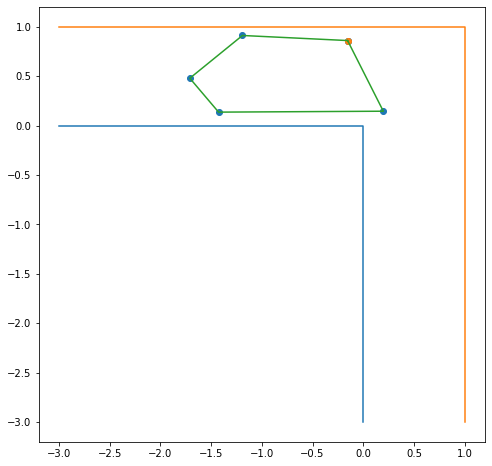

area: 1.14019 vertices: 5


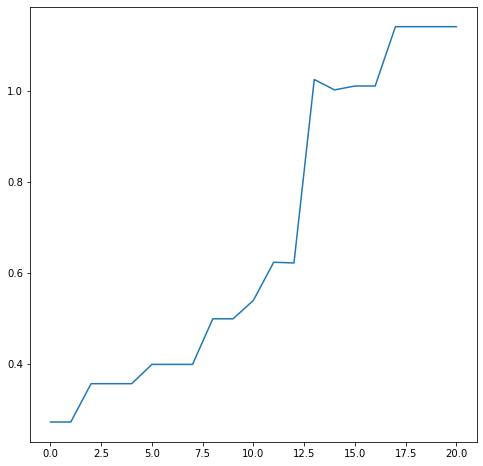

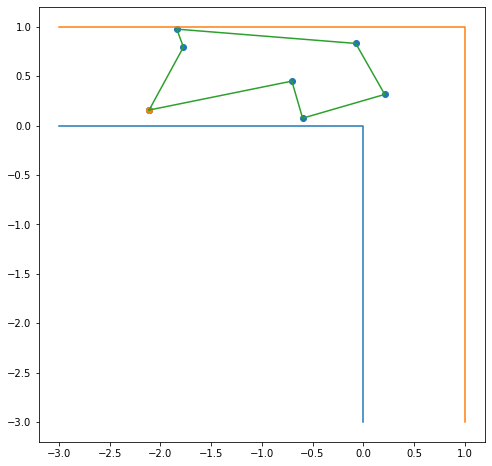

area: 1.24784 vertices: 7


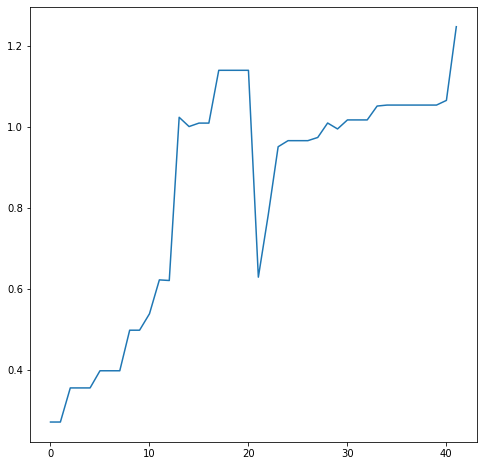

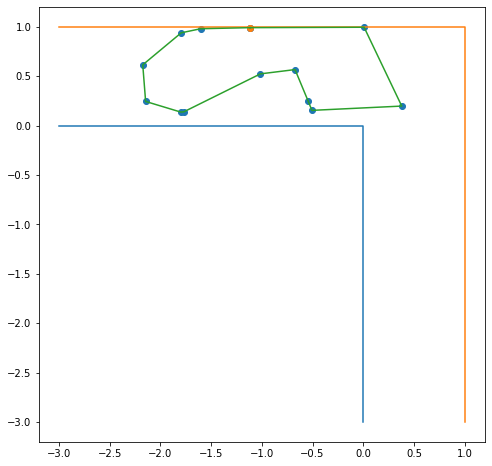

area: 1.56131 vertices: 13


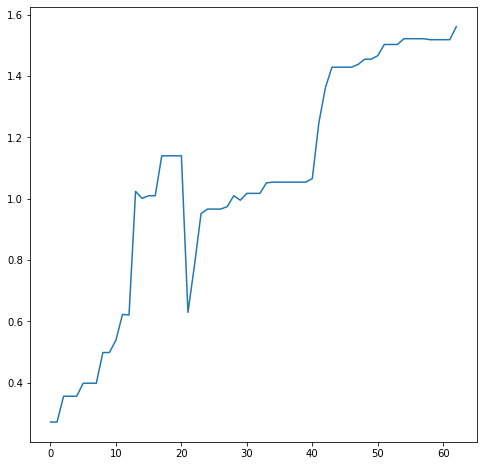

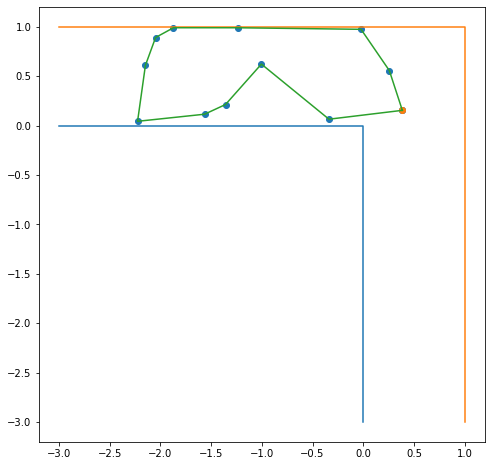

area: 1.80403 vertices: 12


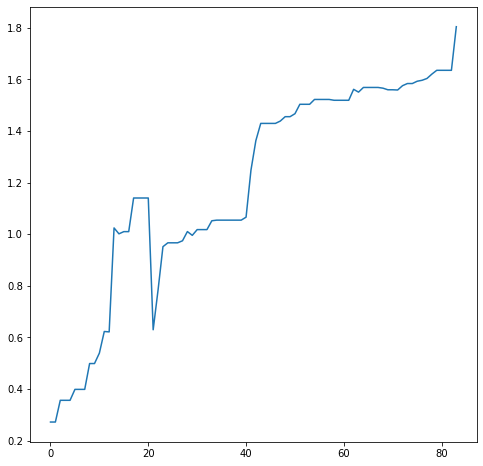

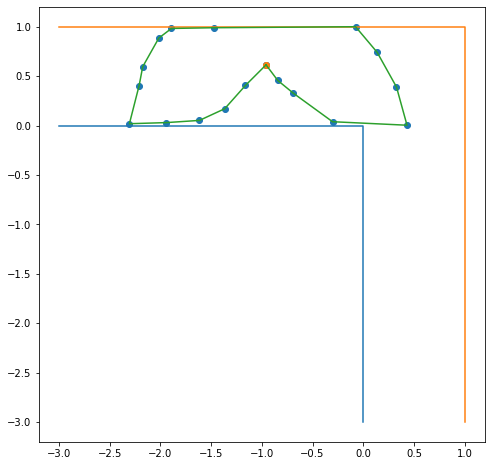

area: 1.96646 vertices: 18


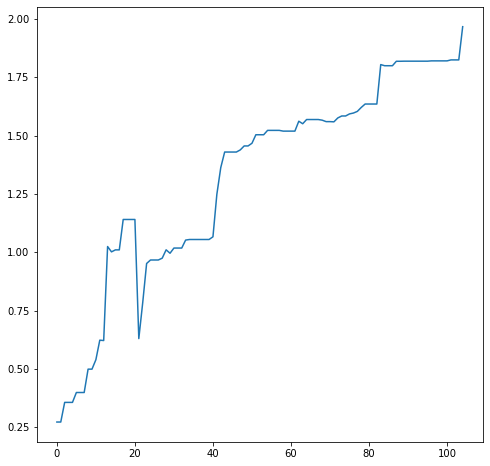

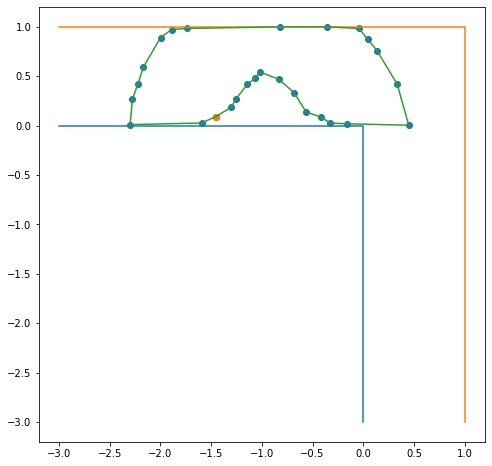

area: 2.04008 vertices: 27


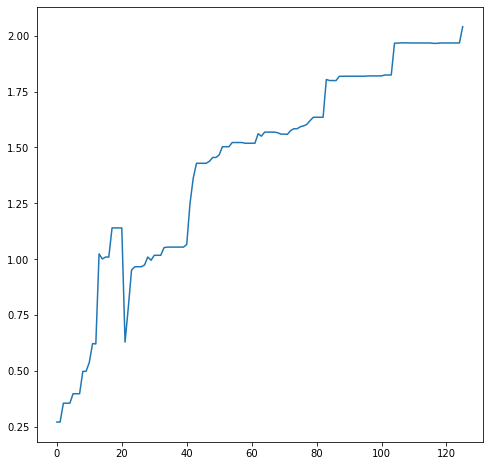

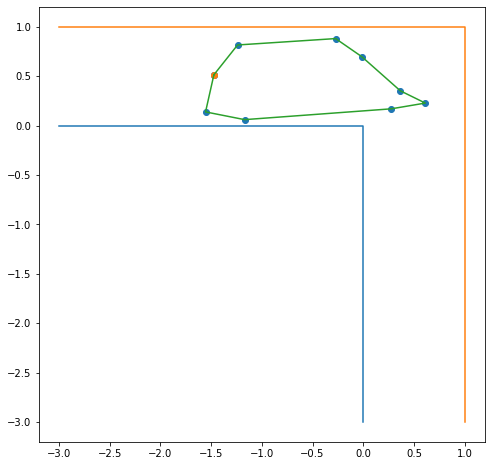

area: 1.20454 vertices: 9


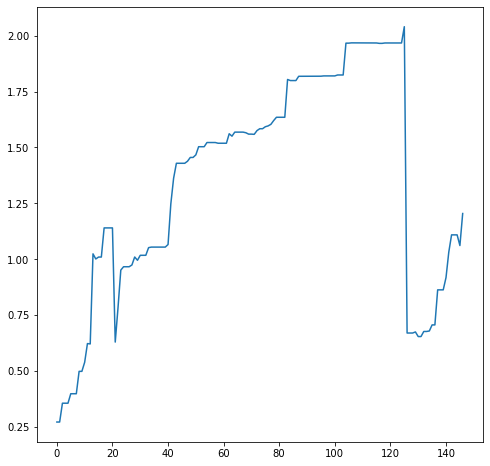

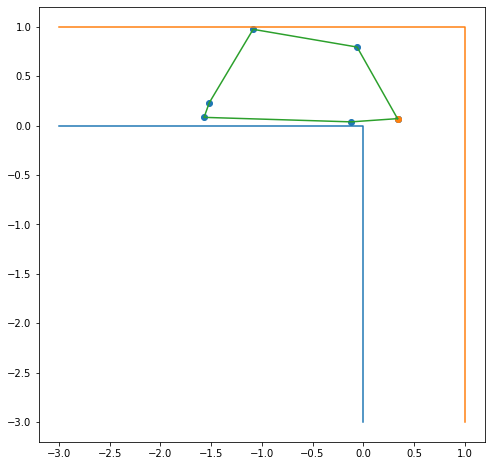

area: 1.23461 vertices: 6


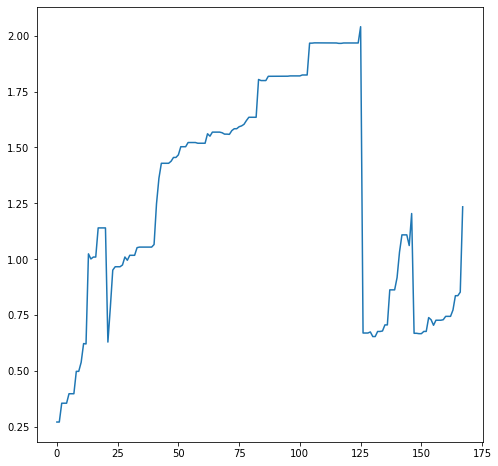

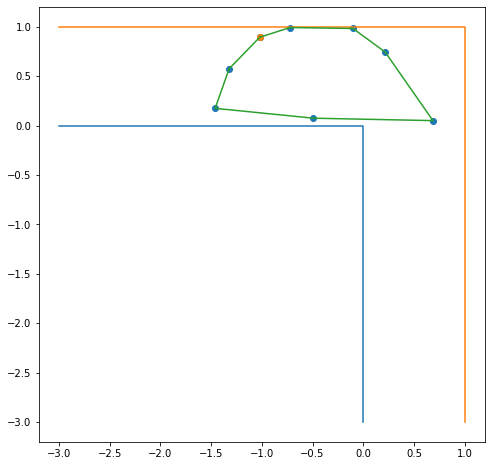

area: 1.43383 vertices: 8


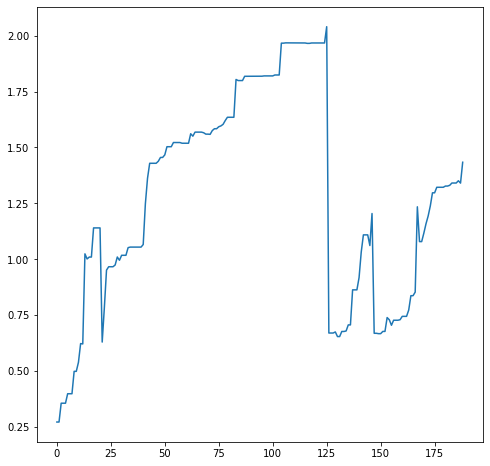

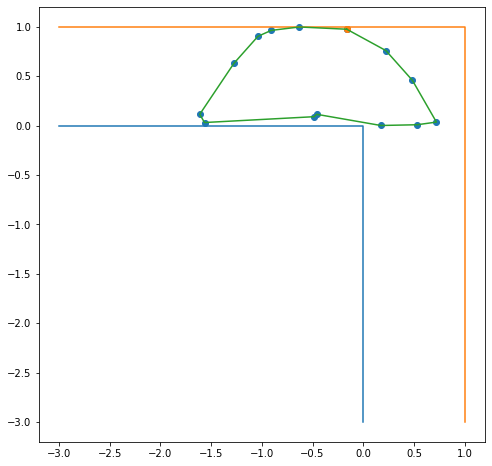

area: 1.59976 vertices: 14


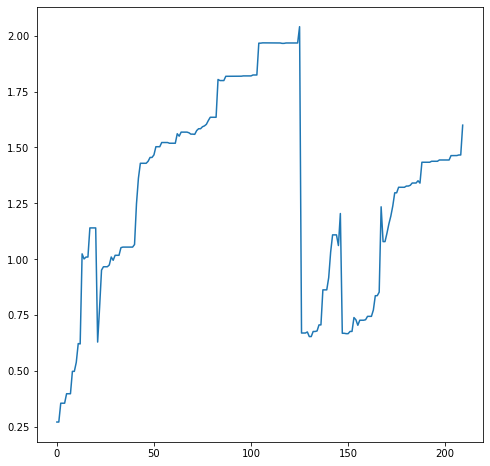

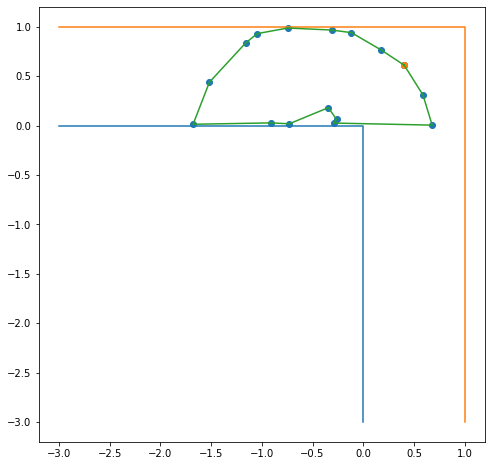

area: 1.68603 vertices: 16


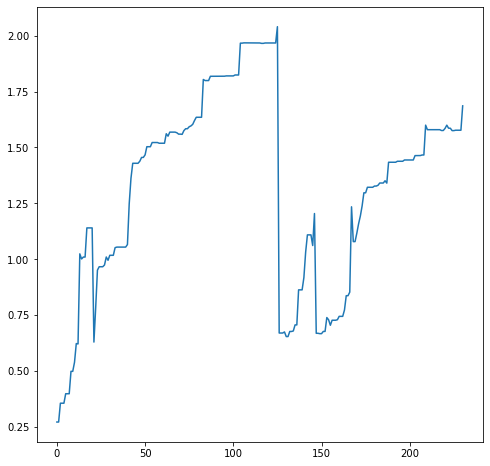

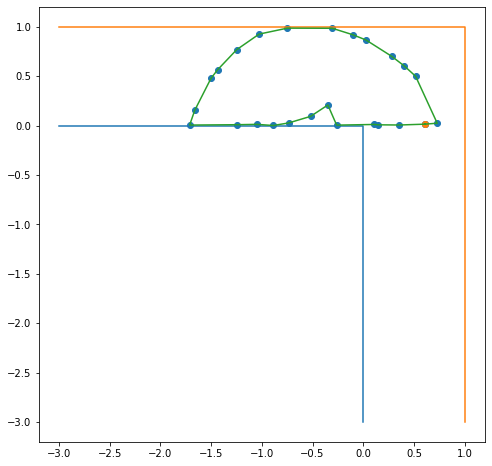

area: 1.74256 vertices: 25


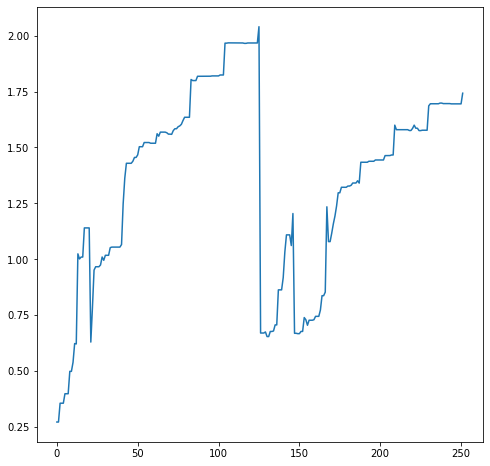

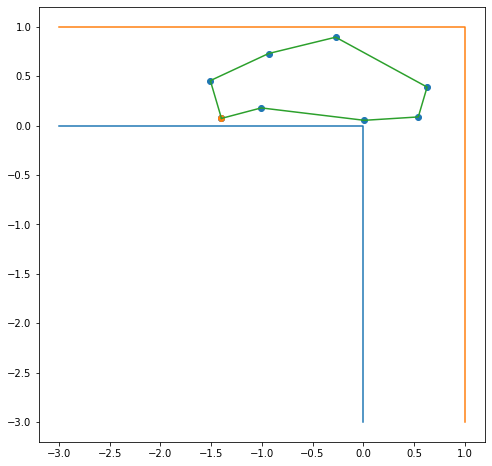

area: 1.20076 vertices: 8


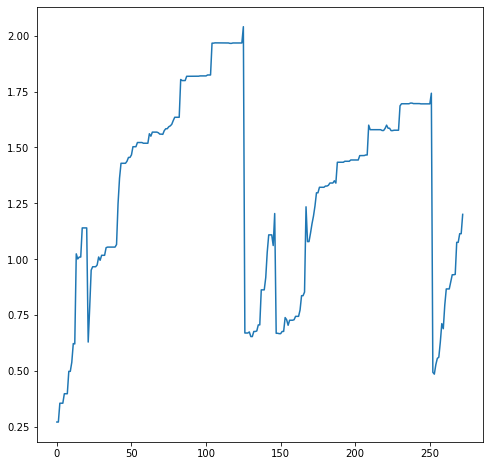

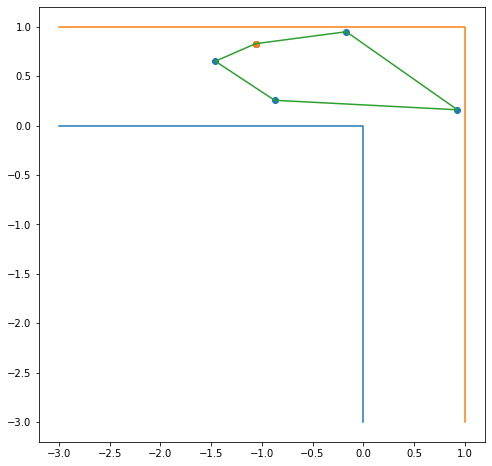

area: 1.0564 vertices: 5


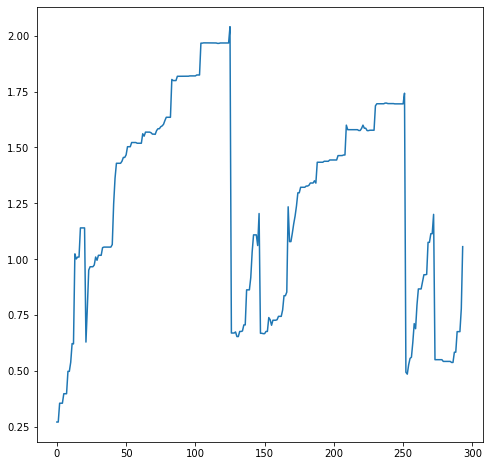

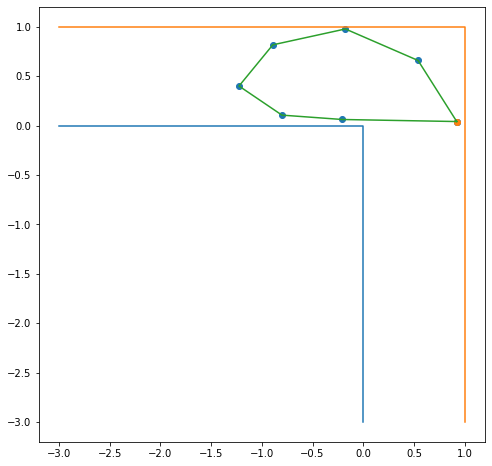

area: 1.34941 vertices: 7


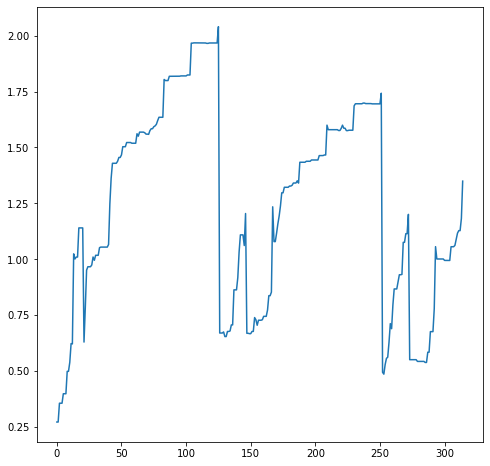

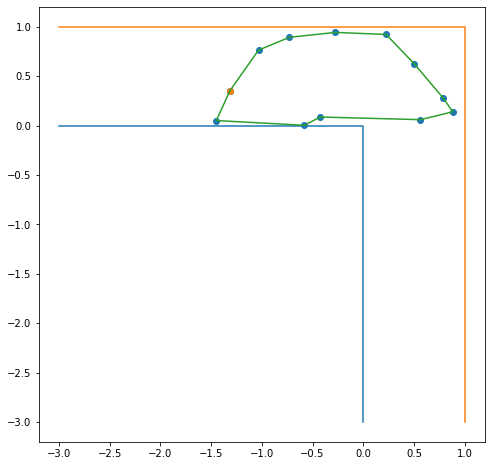

area: 1.54746 vertices: 12


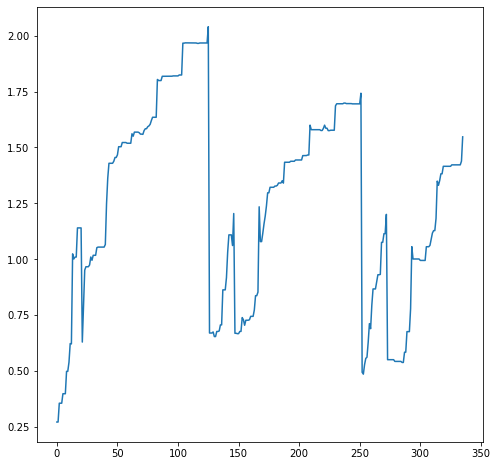

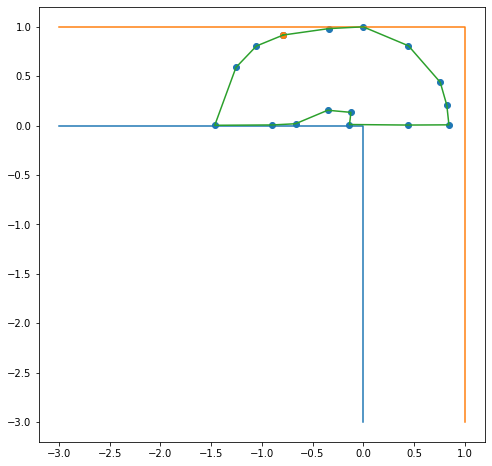

area: 1.74034 vertices: 16


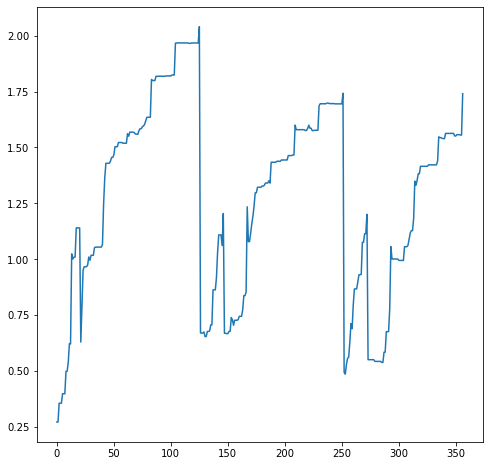

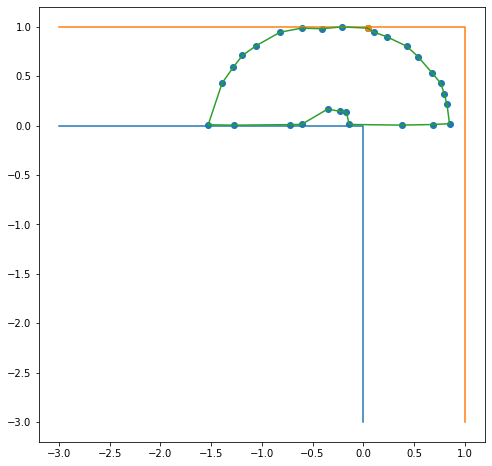

area: 1.81083 vertices: 28


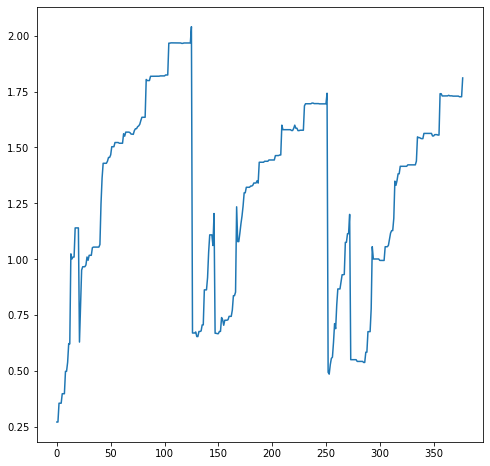

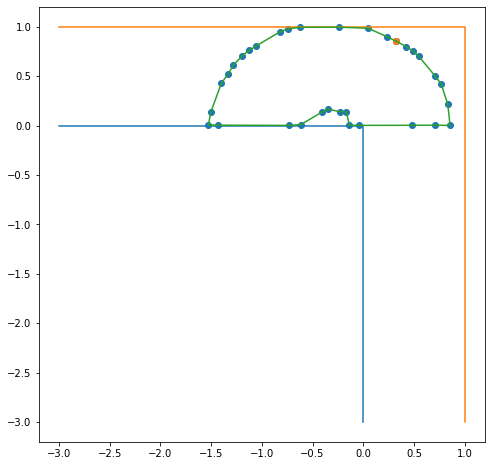

area: 1.8368 vertices: 33


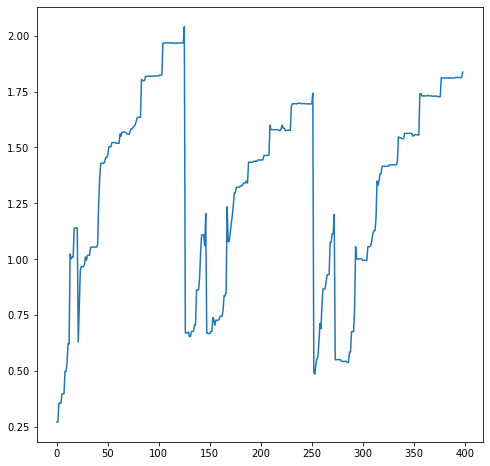

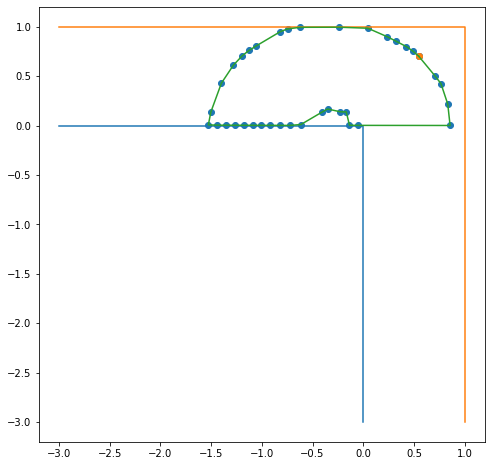

area: 1.83849 vertices: 37


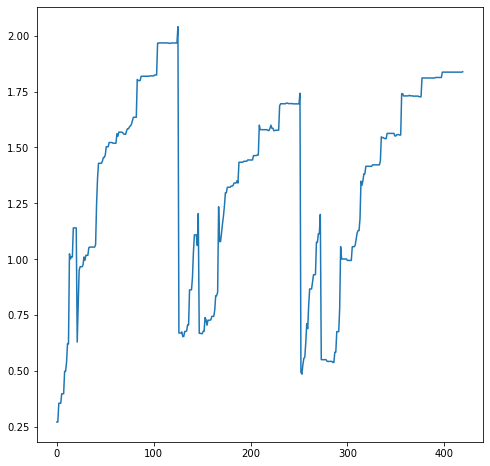

In [5]:
max_steps = 500
parameters = []
for _ in range(3):
    parameters.append((50,0.8))
    parameters.append((70,0.8))
    parameters.append((90,0.5))
    parameters.append((110,0.2))
    parameters.append((150,0.1))
    parameters.append((300,0.05))
parameters.append((1000,0.02))
parameters.append((2000,0.01))
for tempinv,point_spacing in parameters:
    og_point_array = repolygon(og_point_array,point_spacing,max_steps)
    for iteration in range(20):
        working_scale,og_point_array = iterate(max_steps,working_scale,og_point_array,tempinv)
        area_list.append(area(og_point_array))
        tempinv += 1
    og_point_array = reduce_useless_points(og_point_array,max_steps)
    og_point_array = grow(og_point_array,max_steps,point_spacing)
    area_list.append(area(og_point_array))

    plot_fancy_corridor(og_point_array)

    print("area:",round(area(og_point_array),5),"vertices:",len(og_point_array))

    plt.plot(area_list)
    plt.show()

In [6]:
og_point_array = repolygon(og_point_array,point_spacing,max_steps)

In [7]:
pass_through(og_point_array,1000,True)

133


True